In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
import csv
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from collections import defaultdict
import math
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import randint

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# initialize the plotting sizes
# set size
plt.rc('figure', figsize=(15, 8))
# subplots size
fizsize_with_subplots = (15, 8)
# histogram size
bin_size = 10

In [2]:
dates = pd.read_csv('data/dates.csv',header=None)
queries = pd.read_csv('data/queries.csv',header=None)
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

In [3]:
dates['Date'] = pd.to_datetime(dates[0])
y.set_index(dates['Date'],inplace=True)
X.set_index(dates['Date'],inplace=True)

In [4]:
avg_year = pd.read_csv('average_yearly_flu_rate_4018.csv',header=None)

In [5]:
df1 = avg_year.copy()
#df1['rate'] = train1_y2
df1.head()

,0,1
0,2005-08-24,2.687429
1,2005-08-25,2.640713
2,2005-08-26,2.611142
3,2005-08-27,2.627286
4,2005-08-28,2.682714


In [6]:
df=df1.iloc[:,1:2].copy()
df3 = df[:3653].copy()
df4 = df[3653:].copy()

In [7]:
# data preprocessing and train-test split
# this data is well formed with no missing value and other symbols or labels that are non numerical.
# splitting the data into train and test

# Here we want the first 500 queries, ARIAMA only consider y, setting X has no effect
X = X.iloc[:, 0: 500]

# first with the last year as test
# use the last 365 of training set as validation set
test_size =365
val_size=365
length = X.shape[0]
train1_X = X[0:length-test_size*2]
val1_X = X[length-test_size*2:length-test_size]
train1_y = y[0:length-test_size*2]
val1_y = y[length-test_size*2:length-test_size]
test1_X = X[length-test_size:]
test1_y = y[length-test_size:]

#without validation set
train1_X2 = X[0:length-test_size]
train1_y2 = y[0:length-test_size]

# second with the last 2 year as test
test_size2 =365*2
train2_X = X[0:length-test_size2-val_size]
val2_X = X[length-test_size2-val_size:length-test_size2]
train2_y = y[0:length-test_size2-val_size]
val2_y = y[length-test_size2-val_size:length-test_size2]
test2_X = X[length-test_size2:length-test_size]
test2_y = y[length-test_size2:length-test_size]

#without validation set
train2_X2 = X[0:length-test_size2]
train2_y2 = y[0:length-test_size2]

y2 = y[:4018].copy()

print('X shape: ',X.shape,'  y shape: ',y.shape)
print('train1 X:',train1_X.shape,' train1 y:',train1_y.shape,' Test1 X shape:',test1_X.shape, ' Test1 y shape:',test1_y.shape)
print('train2 X:',train2_X.shape,' train2 y:',train2_y.shape,' Test2 X:',test2_X.shape,' Test2 y:',test2_y.shape)

X shape:  (4383, 500)   y shape:  (4383, 1)
train1 X: (3653, 500)  train1 y: (3653, 1)  Test1 X shape: (365, 500)  Test1 y shape: (365, 1)
train2 X: (3288, 500)  train2 y: (3288, 1)  Test2 X: (365, 500)  Test2 y: (365, 1)


In [8]:
df=df1.iloc[:,1:2].copy()
df.head()

,1
0,2.687429
1,2.640713
2,2.611142
3,2.627286
4,2.682714


In [9]:
df.shape

(4018, 1)

In [10]:
## now model selection via AIC
def evaluate_arima_model2(dataset,X, p,d,q):
    # fit model
    model = ARIMA(dataset.values,exog=X,order=(p,d,q))
    model_fit = model.fit(disp=0)
  
    error = model_fit.aic
    return error


## tune the parameters by rmse
def evaluate_models2(dataset,X, p_values, d_values, q_values):
    best_score=1000000000
    p0=-1
    d0=-1
    q0=-1
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    aic = evaluate_arima_model2(dataset,X, p,d,q)
                    if aic < best_score:
                        best_score = aic
                        p0=p
                        d0=d
                        q0=q
                    print(p,',',d,',',q,' AIC:',aic)
                except:
                    continue
    print('Best ARIMA (',p0,',',d0,',',q0,') AIC:',best_score)


In [11]:
train2_y2.shape

(3653, 1)

In [16]:
model2 = sm.tsa.statespace.SARIMAX(endog=train2_y2.values,exog=df[:3653],order=[2,1,15])
model_fit2 = model2.fit(disp=0)
print(model_fit2.summary())

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 3653
Model:              SARIMAX(2, 1, 15)   Log Likelihood               -1516.971
Date:                Wed, 05 Sep 2018   AIC                           3071.942
Time:                        19:41:31   BIC                           3189.800
Sample:                             0   HQIC                          3113.913
                               - 3653                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
1              0.0337      0.099      0.342      0.732      -0.160       0.227
ar.L1          0.8142      3.405      0.239      0.811      -5.859       7.487
ar.L2          0.1449      3.287      0.044      0.9

In [17]:
model2 = sm.tsa.statespace.SARIMAX(endog=train2_y2.values,exog=df[:3653],order=[1,2,15])
model_fit2 = model2.fit(disp=0)
print(model_fit2.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 3653
Model:              SARIMAX(1, 2, 15)   Log Likelihood               -1545.116
Date:                Wed, 05 Sep 2018   AIC                           3126.232
Time:                        19:43:42   BIC                           3237.882
Sample:                             0   HQIC                          3165.993
                               - 3653                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
1              0.0375      0.111      0.337      0.736      -0.181       0.256
ar.L1         -0.0113   2686.700  -4.22e-06      1.000   -5265.846    5265.823
ma.L1          0.0107   2687.647   3.98e-06      1.0

In [18]:
model2 = sm.tsa.statespace.SARIMAX(endog=train2_y2.values,exog=df[:3653],order=[2,1,14])
model_fit2 = model2.fit(disp=0)
print(model_fit2.summary())

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 3653
Model:              SARIMAX(2, 1, 14)   Log Likelihood               -1518.282
Date:                Wed, 05 Sep 2018   AIC                           3072.565
Time:                        19:44:21   BIC                           3184.219
Sample:                             0   HQIC                          3112.327
                               - 3653                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
1              0.0748      0.095      0.783      0.434      -0.112       0.262
ar.L1          0.9594      0.146      6.555      0.000       0.673       1.246
ar.L2          0.0010      0.147      0.007      0.9

In [12]:
# Defien the mearure matrics, MAE, RMSE, CORR
# define three metrics: mean absolute error, root mean squared error and Pearson's correlation.
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)

train1 = train2_y2.values
test1 = test2_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:3653].copy()
df4 = df[3653:].copy()

history = [x for x in train1]
predict = list()
training_mod = sm.tsa.statespace.SARIMAX(endog =train1,
                                  exog=df3,
                                  trend='n', order=(2,1,15),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
training_res = training_mod.fit()

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [21]:
train1 = train2_y2.values
test1 = test2_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:3653].copy()
df4 = df[3653:].copy()

history = [x for x in train1]
predict = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:3653+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,15),
                                      
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4.iloc[[t]]
    output = model_fit.forecast(steps=1,exog=exog_test)
    yhat = output.values[0]
    print(yhat)
    predict.append(yhat)
    obs = test1[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict)
rmse1 = sqrt(mean_squared_error(test1, predict))

corr_y = test2_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict
corr2 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr2)

1.8908369578306268
1
1.8011351208565094
2
1.704204404059743
3
1.6564377113303204
4
1.8900516352731989
5
1.987285413503737
6
2.080488903073156
7
2.174390635497413
8
2.269675683228766
9
2.363253062503272
10
2.4277910636747
11
2.4179790197896063
12
2.4432297431337244
13
2.4711788642670243
14
2.499035523332401
15
2.5270209358192
16
2.5521136580439876
17
2.536590038362369
18
2.8576508584708082
19
3.0193163113490327
20
3.1736075899904574
21
3.327963809521438
22
3.487896655118842
23
3.6410535718793664
24
3.7156330947925253
25
3.673398835199078
26
3.690250525447397
27
3.7075867028400733
28
3.7257734370317244
29
3.741573804559583
30
3.7576593459456387
31
3.7334078708449616
32
3.9888548014346443
33
4.1073421941179165
34
4.226224942674488
35
4.342521217981894
36
4.462092168853879
37
4.579914168796396
38
4.641124026140268
39
4.99275143875734
40
5.203463493471743
41
5.410459370509347
42
5.620239656478516
43
5.831974414275417
44
6.037182037826998
45
6.10463493513311
46
6.387071899707195
47
6.5670382

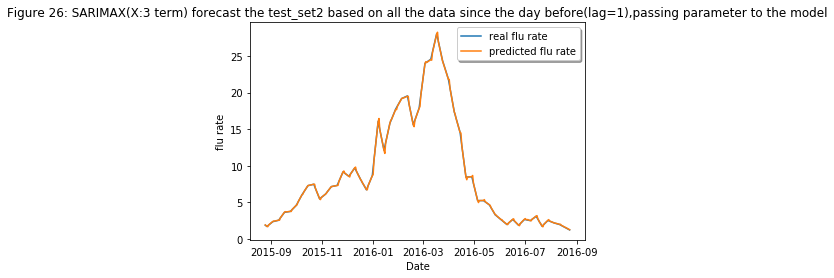

In [24]:
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],predict,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 26: SARIMAX(X:3 term) forecast the test_set2 based on all the data since the day before(lag=1),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [13]:
## lag=5
train1 = train2_y2.values[:3653-4]
test = y.values[3653-4:]
test1 = test2_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:3653].copy()
df4 = df[3653-4:].copy()


history = [x for x in train1]
predict2 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:3653-4+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,15),
                                     
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+5]
    output = model_fit.forecast(steps=5,exog=exog_test)
    yhat = output.values[4]
    print(yhat)
    predict2.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict2)
rmse1 = sqrt(mean_squared_error(test1, predict2))

corr_y = test2_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict2
corr2 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr2)

2.756565064558912
1
2.13657952177829
2
2.0664901811900718
3
2.0286415064857657
4
1.975755838000359
5
1.9188563713584355
6
1.8518553610278994
7
1.8141848370872866
8
2.5801591646232853
9
2.6843865977644925
10
2.743977045683779
11
2.808303195586384
12
2.872010186840783
13
2.928811606243384
14
2.9879881428447037
15
2.836527946245715
16
2.859530823283813
17
2.8489873318673644
18
2.831489593543369
19
2.8142244530072067
20
2.7943458947186586
21
2.786813710487536
22
3.7502698274798156
23
3.930772340340542
24
4.000303365352337
25
4.07381904049797
26
4.152122755132369
27
4.204344013962868
28
4.266129834376406
29
4.000807374876825
30
4.0167131457733
31
3.991308726641597
32
3.9633033436191796
33
3.9303419340256878
34
3.9065574242399954
35
3.8913381869129298
36
4.678433399061971
37
4.811989216021888
38
4.886045359996772
39
4.949677659800347
40
5.018987430238029
41
5.071533809859958
42
5.116155070459696
43
5.995536146315455
44
6.195274030623807
45
6.243335718415598
46
6.303076570161396
47
6.36632476

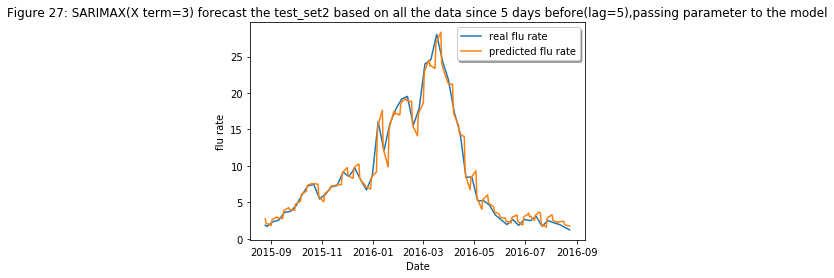

In [14]:
## lag=5
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],predict2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 27: SARIMAX(X term=3) forecast the test_set2 based on all the data since 5 days before(lag=5),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [15]:
## lag=10
train1 = train2_y2.values[:3653-9]
test = y.values[3653-9:]
test1 = test2_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:3653].copy()
df4 = df[3653-9:].copy()


history = [x for x in train1]
predict3 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:3653-9+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,15),
                                      
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+10]
    output = model_fit.forecast(steps=10,exog=exog_test)
    yhat = output.values[9]
    print(yhat)
    predict3.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict3)
rmse1 = sqrt(mean_squared_error(test1, predict3))

corr_y = test2_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict3
corr2 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr2)

3.4990624382515447
1
3.5494295117819172
2
3.571660785120373
3
3.582703430403776
4
3.5672314180976366
5
3.573221523163176
6
2.718305414581744
7
2.701420909045856
8
2.6690422343270335
9
2.618887941890316
10
2.612381271485718
11
2.593860257263329
12
2.615152665486243
13
3.698829642109143
14
3.771717022438221
15
3.8224875148305975
16
3.879293563177496
17
3.8732468237848066
18
3.8558741689273313
19
3.8470799030467564
20
3.5607776652246663
21
3.5440379181775246
22
3.5439373682757607
23
3.541763166637436
24
3.5526856853273503
25
3.558632231577121
26
3.576880916530992
27
4.877728384865563
28
4.976764686087085
29
5.025968088420336
30
5.081691885170526
31
5.070884001157405
32
5.025915422075405
33
4.998217890198717
34
4.542526570073853
35
4.519084933666963
36
4.498129237623372
37
4.483042772284396
38
4.490518236207147
39
4.509539776523791
40
4.537341182006278
41
5.626219427621652
42
5.707122898014017
43
5.775861846388809
44
5.823633067911939
45
5.8119834415648395
46
5.776799210535575
47
5.7381730

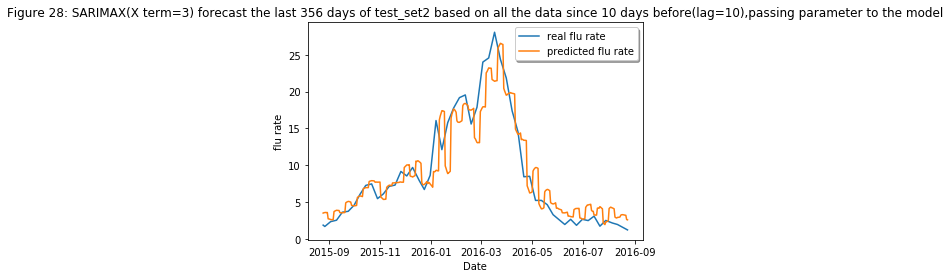

In [16]:
# visualize lag=10
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],predict3,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 28: SARIMAX(X term=3) forecast the last 356 days of test_set2 based on all the data since 10 days before(lag=10),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [17]:
## lag=14
train1 = train2_y2.values[:3653-13]
test = y.values[3653-13:]
test1 = test2_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:3653].copy()
df4 = df[3653-13:].copy()

history = [x for x in train1]
predict4 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:3653-13+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,15),
                                      
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+14]
    output = model_fit.forecast(steps=14,exog=exog_test)
    yhat = output.values[13]
    print(yhat)
    predict4.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict4)
rmse1 = sqrt(mean_squared_error(test1, predict4))

corr_y = test2_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict4
corr2 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr2)

3.870103110961807
1
3.865253407714407
2
3.8741317622234868
3
4.276005924009329
4
4.264265541483706
5
4.294939535322836
6
4.2957793337780865
7
4.308164877051741
8
4.29122786343835
9
4.295257273388618
10
3.4039298575560824
11
3.4440787669091515
12
3.4654796951465374
13
3.4661664908113328
14
3.4591807135927546
15
3.4386016492402334
16
3.463749688444356
17
4.5917879150589815
18
4.593952277795491
19
4.5761334277682355
20
4.568709338979103
21
4.565396328944335
22
4.554919118358943
23
4.55413928982046
24
4.265898815148283
25
4.273887528946142
26
4.2949995159439425
27
4.309122692633253
28
4.31908604610682
29
4.319154946063093
30
4.333762501750227
31
5.682677133816654
32
5.695436452491906
33
5.658384291101274
34
5.633827000558748
35
5.622322886843057
36
5.572586732366169
37
5.551420785575784
38
5.09126762309195
39
5.105847168097895
40
5.124322840987054
41
5.1403639650395565
42
5.1498000858845066
43
5.172475543732434
44
5.194650350853651
45
6.317128832120888
46
6.318766860283563
47
6.31051239069

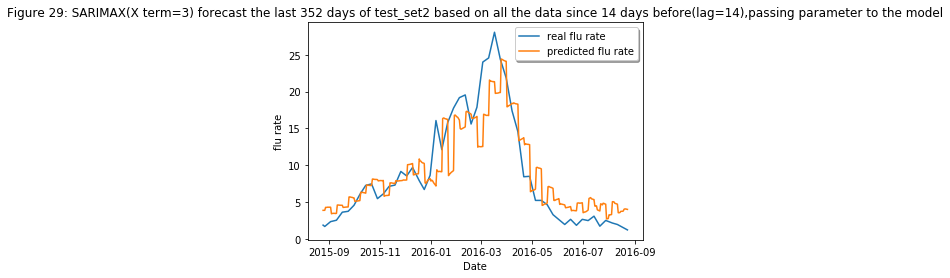

In [18]:
# visualize lag=14
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],predict4,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 29: SARIMAX(X term=3) forecast the last 352 days of test_set2 based on all the data since 14 days before(lag=14),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [19]:
## lag=28
train1 = train2_y2.values[:3653-27]
test = y.values[3653-27:]
test1 = test2_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:3653].copy()
df4 = df[3653-27:].copy()

history = [x for x in train1]
predict5 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:3653-27+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,15),
                                      
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+28]
    output = model_fit.forecast(steps=28,exog=exog_test)
    yhat = output.values[27]
    print(yhat)
    predict5.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict5)
rmse1 = sqrt(mean_squared_error(test1, predict5))

corr_y = test2_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict5
corr2 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr2)

5.700120047275318
1
5.699687161279664
2
5.708724567459278
3
5.932186841515701
4
5.929889863565086
5
6.018854255738993
6
6.016934331255024
7
6.023340262434635
8
6.013111617571225
9
6.014328541086143
10
6.042922299339418
11
6.039146287048547
12
6.041827604993548
13
6.039617526790964
14
6.0437179190504295
15
6.040248073488446
16
6.04898510885045
17
6.288012978786429
18
6.282543713556532
19
6.302968833371854
20
6.307455262909038
21
6.3196802813371376
22
6.310976530904275
23
6.323081930544778
24
5.810293255267907
25
5.843320188385318
26
5.864016216057152
27
5.872140806399081
28
5.877154883459075
29
5.869728541816697
30
5.888243082239207
31
6.558045091347405
32
6.56642854484676
33
6.558445302769195
34
6.555522572127933
35
6.555637940096078
36
6.538342550761994
37
6.5384353994198365
38
6.373833785817045
39
6.380628450976253
40
6.39823310219235
41
6.411124809869819
42
6.422431240084813
43
6.4340259511023055
44
6.445257907833385
45
7.241565843282873
46
7.247972846338531
47
7.227509973389356
48


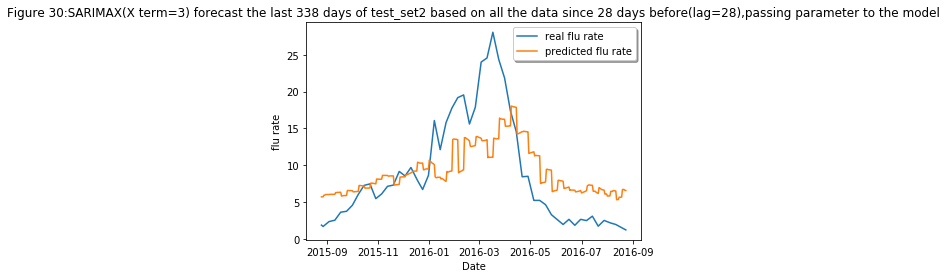

In [20]:
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],predict5,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 30:SARIMAX(X term=3) forecast the last 338 days of test_set2 based on all the data since 28 days before(lag=28),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()